In [1]:
import numpy as np
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
import astropy
from astropy import constants as c
from astropy import units as u
import scipy.integrate as integrate
import csv

In [64]:
# Ganymede data

r_ref = 2631.2 * u.km # reference radius, from Gomez Casajus et al. (2022)
r_mean = 2634.1 * u.km # mean radius, wikipedia
r_orb = 1070400 * u.km # current orbital radius, wikipedia


period = 7.15455296 * u.day # wikipedia, T_orb = T_rot
rot_rate = 2*np.pi/period

mass = 1.4819e26 * u.g # wikipedia


J2_measured = 133.0/1e6 # from Gomez Casajus et al. (2022), table S2
J2_unc = 6.8/1e6 # from Gomez Casajus et al. (2022), table S2

C22 = 39.56/1e6 # from Gomez Casajus et al. (2022), table S2
C22_unc = 1.73/1e6 # from Gomez Casajus et al. (2022), table S2

# ice data
poisson = 0.30 # Cameron et al. 2020
rigidity = 3.49 * u.GPa # Shear modulus, Cameron et al. 2020
iceDensity = 0.92 * u.g/u.cm**3

oceanDensity = 1.0 * u.g/u.cm**3
intDensity = 2.184 * u.g/u.cm**3

J2C22ratio = J2_measured/C22
J2C22ratio_unc = np.sqrt((J2_unc/J2_measured)**2 + (C22_unc/C22)**2)

J2_hydro = C22 * 10/3
J2_nonhydro = J2_measured - J2_hydro

In [3]:
R = r_mean
# M = mass
G = c.G
sig = poisson
mu = rigidity
pIce = iceDensity
pOcean = oceanDensity
pInt = intDensity
pi = np.pi
Tf = period

r1 = 2436.9 * u.km
r2 = 2614.1 * u.km

In [14]:
massInt1 = lambda r: 4 * pi * r**2 * pInt.value
massInt2 = lambda r: 4 * pi * r**2 * pOcean.value
massInt3 = lambda r: 4 * pi * r**2 * pIce.value

M_unitless = integrate.quad(massInt1, 0, (r1.cgs).value)[0] + integrate.quad(massInt2, (r1.cgs).value, (r2.cgs).value)[0] + integrate.quad(massInt3, (r2.cgs).value, (R.cgs).value)[0]
M = M_unitless * u.g

<Quantity 1.48190368e+26 g>

In [23]:
def P2(theta):
    '''
    l = 2 Legendre Polynomial
    '''
    cosine = np.cos(theta)
    return 1/2 * (3*cosine**2 - 1)

def Ti(r_start):
    '''
    wherein r_start is a fraction of the current radius (free parameter, varies between 0.5 - 0.9)
    '''
    return Tf * r_start**(3/2)

def omega0(r_start):
    '''
    wherein r_start is a fraction of the current radius (free parameter, varies between 0.5 - 0.9)
    '''
    return 2*pi/Ti(r_start)

# assuming change in r is negligible since max change of radius is 0.1% --> 0.3% in m0
def m0(r_start):
    '''
    takes initial period as defined by r_start, outputs initial m
    '''
    w = 2*pi/Ti(r_start)
    return (w**2 * (R)**3 / G / M).cgs

m_now = m0(1)

def Td(r_start):
    '''
    time constant for despinning, assuming current rotation rate @ t = 4.5 Gyr
    output in Gyr
    '''    
    return 4.5 * u.Gyr / np.log(m0(r_start)/m_now)

def m(t, r_start):
    '''
    now with time dependence (must be input in units of Gyr)!
    '''
    return m0(r_start) * np.exp(-t / Td(r_start))

def omega(t, r_start):
    '''
    rotation rate vs time
    '''
    return omega0(r_start) * np.exp(-t / (2*Td(r_start)))

def ellipticity(omega):
    '''
    ellipticity vs rotation rate (first order approx)
    '''
    return 5 * R**3 * omega**2/(2*G*(5*M - 4*pi*R**3*pIce))

def local_radius(eps, theta):
    '''
    eps (ellipticity) can be entered as a function of something
    '''
    return R * (1-2/3 * eps * P2(theta))

def beta(r_start, r_fracChange=0.001):
    '''
    max r_fracChange = 0.1% = 0.001
    '''
    return 2 * (1+sig)/(1-sig) * r_fracChange / (5/12 * (1+sig)/(5+sig) * 10 * m0(r_start))

def gamma(r_start, Y):
    '''
    Y must be in units of pressure
    '''
    Y = Y.to(u.GPa)
    return 5/12 * m0(r_start) * mu * (1+sig)/(5+sig) * 10 / Y

def stress_theta(lat, Y, alpha, beta, gamma, Td, t):
    '''
    lat = latitude, Y = yield stress, alpha = Td/Te, t = time (needs units)
    beta, gamma, Td need to be input as functions
    '''
    return Y*(-1/10 * (5-3*np.cos(2*lat)) * gamma * (1-np.exp(-t/Td)) + beta*gamma*(1-np.exp(-alpha*t/Td)))
    
def stress_phi(lat, Y, alpha, beta, gamma, Td, t):
    '''
    lat = latitude, Y = yield stress, alpha = Td/Te, t = time
    beta, gamma, Td need to be input as functions
    '''
    return Y*(1/10 * (1+9*np.cos(2*lat)) * gamma * (1-np.exp(-t/Td)) + beta*gamma*(1-np.exp(-alpha*t/Td)))

def stress_theta_timeDeriv(lat, Y, alpha, beta, gamma, Td, t):
    '''
    lat = latitude, Y = yield stress, alpha = Td/Te, t = time
    beta, gamma, Td need to be input as functions
    '''
    return Y * (-1/10 * (5-3*np.cos(2*lat)) * gamma * np.exp(-t/Td) / Td + alpha*beta*gamma*np.exp(-alpha*t/Td)/Td)

def stress_phi_timeDeriv(lat, Y, alpha, beta, gamma, Td, t):
    '''
    lat = latitude, Y = yield stress, alpha = Td/Te, t = time
    beta, gamma, Td need to be input as functions
    '''
    return Y*(1/10 * (1+9*np.cos(2*lat)) * gamma * np.exp(-t/Td)/Td + alpha*beta*gamma*np.exp(-alpha*t/Td)/Td)

# calculate some constant stuff, makes functions faster. Everything in CGS
funcJ2_int = lambda r: r**4 * pInt.value
funcJ2_ocean = lambda r: r**4 * pOcean.value

J2_int = integrate.quad(funcJ2_int, 0, (r1.cgs).value)[0]
J2_ocean = integrate.quad(funcJ2_ocean, (r1.cgs).value, (r2.cgs).value)[0]

def J2(lat, lat_step, ellipticity):
    '''
    lat, lat_step must be radians
    ellipticity is fxn of things
    '''
    if lat == 0:
        lower_theta = max(0, pi/2 - lat_step)
        upper_theta = min(pi/2 + lat_step, pi)
        # single integral part (theta integral * ocean and int parts)
        func_theta = lambda theta: P2(theta) * np.sin(theta)
        theta_int_only = integrate.quad(func_theta, lower_theta, upper_theta)[0]
        constpart = theta_int_only * (J2_int+J2_ocean)
        
        # double integral part (theta integral * ice part)
        func_theta_r = lambda r, theta: P2(theta) * np.sin(theta) * r**4 * pIce.value
        theta_r_int = integrate.dblquad(func_theta_r, lower_theta, upper_theta, (r2.cgs).value, lambda theta: (R.cgs).value*(1- 2/3*ellipticity*P2(theta)))[0]
        
        J2_tot = -2*pi/(M.cgs).value/((R.cgs).value)**2 * (constpart + theta_r_int)
        
    if lat != 0:
        lower_theta = max(0, pi/2 - lat - lat_step)
        upper_theta = min(pi/2 - lat + lat_step, pi)
        # single integral part (theta integral * ocean and int parts)
        func_theta = lambda theta: P2(theta) * np.sin(theta)
        theta_int_only = integrate.quad(func_theta, lower_theta, upper_theta)[0]
        constpart = theta_int_only * (J2_int+J2_ocean)
        
        # double integral part (theta integral * ice part)
        func_theta_r = lambda r, theta: P2(theta) * np.sin(theta) * r**4 * pIce.value
        theta_r_int = integrate.dblquad(func_theta_r, lower_theta, upper_theta, (r2.cgs).value, lambda theta: (R.cgs).value*(1- 2/3*ellipticity*P2(theta)))[0]
        
        J2_tot = -4*pi/(M.cgs).value/((R.cgs).value)**2 * (constpart + theta_r_int)
    
    return J2_tot

In [40]:
def fracture_sim(t, lat, r_start, alpha, Y):
    '''
    t --> array of time steps
    lat --> array of latitudes
    r_start (as before) - is fraction of current orbital radius
    alpha (as before) - Td/Te
    Y (as before) - include units
    '''
    print(f'Running model with r_start = {r_start}*r_current, alpha = {alpha}, Y = {Y.value} bars')
    n_timesteps = len(t)
    n_lats = len(lat)
    
    lat_step = (lat[1] - lat[0])/2
    
    stress_theta_array = np.zeros((n_timesteps, n_lats)) * u.bar
    stress_phi_array = np.zeros((n_timesteps, n_lats)) * u.bar
    stress_diff_array = np.zeros((n_timesteps, n_lats)) * u.bar
    shape_array = np.zeros((n_timesteps, n_lats)) * u.km
    failure_timestep = np.zeros(n_lats) * u.Gyr
    J2_vs_lat = np.zeros(n_lats)
    ellipticity_vs_time = np.zeros(n_timesteps)
    rotation_vs_time = np.zeros(n_timesteps) /u.s
    
#     tI = Ti(r_start)
#     w0 = omega0(r_start)
    Beta = beta(r_start)
    Gamma = gamma(r_start, Y)
    tD = Td(r_start)
    
    for i in range(n_timesteps):
        time = t[i]
        rotation_vs_time[i] = omega(time, r_start)
        ellipticity_vs_time[i] = ellipticity(rotation_vs_time[i])
    
    for j in range(n_lats):
        if (j+1) % 5 ==0:
            print(lat[j])
        fail_time = 0
        perm_local_rad = 0
        latitude = lat[j]
        polar = pi/2 - latitude
        for i in range(n_timesteps):
            time = t[i]                
            theta = stress_theta(latitude, Y, alpha, Beta, Gamma, tD, time)
            phi = stress_phi(latitude, Y, alpha, Beta, Gamma, tD, time)
            if theta > phi:
                print(f'warning: theta > phi for t = {time}, lat = {latitude}')
            diff = np.abs(theta - phi)
            stress_theta_array[i][j] = theta
            stress_phi_array[i][j] = phi
            stress_diff_array[i][j] = diff
            shape_array[i][j] = local_radius(ellipticity_vs_time[i], polar)
            
            if diff > Y:
                failure_timestep[j] = time
                fail_time = i
                perm_local_rad = local_radius(ellipticity_vs_time[i], polar)
                J2_local = J2(latitude, lat_step, ellipticity_vs_time[i])
                J2_vs_lat[j] = J2_local
                break
        
        for i in range(fail_time + 1, n_timesteps):
            t1 = t[i-1]
            t2 = t[i]
            del_T = t2 - t1
            
            theta_deriv = stress_theta_timeDeriv(latitude, Y, alpha, Beta, Gamma, tD, t1)
            phi_deriv = stress_phi_timeDeriv(latitude, Y, alpha, Beta, Gamma, tD, t1)
            
            theta_old = stress_theta_array[i-1][j]
            theta_new = stress_theta_array[i-1][j] + theta_deriv*del_T
            
            phi_old = stress_phi_array[i-1][j]
            phi_new = stress_phi_array[i-1][j] + phi_deriv*del_T
            
            diff_new = np.abs(phi_new - theta_new)
            
            if diff_new > Y:
                stress_theta_array[i][j] = theta_old
                stress_phi_array[i][j] = phi_old
            if diff_new <= Y:
                stress_theta_array[i][j] = theta_new
                stress_phi_array[i][j] = phi_new
            stress_diff_array[i][j] = np.abs(stress_phi_array[i][j] - stress_theta_array[i][j])
            shape_array[i][j] = perm_local_rad
    
    for i in range(len(failure_timestep)):
        if failure_timestep[i] == 0 * u.Gyr:
            failure_timestep[i] = t[-1]
    
    for i in range(len(J2_vs_lat)):
        if J2_vs_lat[i] == 0:
            J2_vs_lat[i] = J2(lat[i], lat_step, ellipticity_vs_time[-1])
    print('\n')
    return stress_theta_array, stress_phi_array, stress_diff_array, shape_array, failure_timestep, J2_vs_lat, ellipticity_vs_time, rotation_vs_time

In [41]:
t_unitless = np.linspace(0, 4.5, 4501)
t_unit = [t_unitless[i] * u.Gyr for i in range(len(t_unitless))]
lat_degrees = np.linspace(0, 89, 30)
lat_radians = [lat_degrees[i] * np.pi/180 for i in range(len(lat_degrees))]

In [43]:
theta_020_010_5, phi_020_010_5, diff_020_010_5, shape_020_010_5, fail_020_010_5, J2_020_010_5, eps_020_010_5, rot_020_010_5 = fracture_sim(t_unit, lat_radians, 0.2, 0.1, 5*u.bar)
# theta_025_010_5, phi_025_010_5, diff_025_010_5, shape_025_010_5, fail_025_010_5, J2_025_010_5, eps_025_010_5, rot_025_010_5 = fracture_sim(t_unit, lat_radians, 0.25, 0.1, 5*u.bar)
theta_030_010_5, phi_030_010_5, diff_030_010_5, shape_030_010_5, fail_030_010_5, J2_030_010_5, eps_030_010_5, rot_030_010_5 = fracture_sim(t_unit, lat_radians, 0.3, 0.1, 5*u.bar)
# theta_035_010_5, phi_035_010_5, diff_035_010_5, shape_035_010_5, fail_035_010_5, J2_035_010_5, eps_035_010_5, rot_035_010_5 = fracture_sim(t_unit, lat_radians, 0.35, 0.1, 5*u.bar)
theta_040_010_5, phi_040_010_5, diff_040_010_5, shape_040_010_5, fail_040_010_5, J2_040_010_5, eps_040_010_5, rot_040_010_5 = fracture_sim(t_unit, lat_radians, 0.4, 0.1, 5*u.bar)
# theta_045_010_5, phi_045_010_5, diff_045_010_5, shape_045_010_5, fail_045_010_5, J2_045_010_5, eps_045_010_5, rot_045_010_5 = fracture_sim(t_unit, lat_radians, 0.45, 0.1, 5*u.bar)
theta_050_010_5, phi_050_010_5, diff_050_010_5, shape_050_010_5, fail_050_010_5, J2_050_010_5, eps_050_010_5, rot_050_010_5 = fracture_sim(t_unit, lat_radians, 0.5, 0.1, 5*u.bar)
# theta_055_010_5, phi_055_010_5, diff_055_010_5, shape_055_010_5, fail_055_010_5, J2_055_010_5, eps_055_010_5, rot_055_010_5 = fracture_sim(t_unit, lat_radians, 0.55, 0.1, 5*u.bar)
theta_060_010_5, phi_060_010_5, diff_060_010_5, shape_060_010_5, fail_060_010_5, J2_060_010_5, eps_060_010_5, rot_060_010_5 = fracture_sim(t_unit, lat_radians, 0.6, 0.1, 5*u.bar)
# theta_065_010_5, phi_065_010_5, diff_065_010_5, shape_065_010_5, fail_065_010_5, J2_065_010_5, eps_065_010_5, rot_065_010_5 = fracture_sim(t_unit, lat_radians, 0.65, 0.1, 5*u.bar)
theta_070_010_5, phi_070_010_5, diff_070_010_5, shape_070_010_5, fail_070_010_5, J2_070_010_5, eps_070_010_5, rot_070_010_5 = fracture_sim(t_unit, lat_radians, 0.7, 0.1, 5*u.bar)
# theta_075_010_5, phi_075_010_5, diff_075_010_5, shape_075_010_5, fail_075_010_5, J2_075_010_5, eps_075_010_5, rot_075_010_5 = fracture_sim(t_unit, lat_radians, 0.75, 0.1, 5*u.bar)
theta_080_010_5, phi_080_010_5, diff_080_010_5, shape_080_010_5, fail_080_010_5, J2_080_010_5, eps_080_010_5, rot_080_010_5 = fracture_sim(t_unit, lat_radians, 0.8, 0.1, 5*u.bar)
# theta_085_010_5, phi_085_010_5, diff_085_010_5, shape_085_010_5, fail_085_010_5, J2_085_010_5, eps_085_010_5, rot_085_010_5 = fracture_sim(t_unit, lat_radians, 0.85, 0.1, 5*u.bar)
theta_090_010_5, phi_090_010_5, diff_090_010_5, shape_090_010_5, fail_090_010_5, J2_090_010_5, eps_090_010_5, rot_090_010_5 = fracture_sim(t_unit, lat_radians, 0.9, 0.1, 5*u.bar)
# theta_095_010_5, phi_095_010_5, diff_095_010_5, shape_095_010_5, fail_095_010_5, J2_095_010_5, eps_095_010_5, rot_095_010_5 = fracture_sim(t_unit, lat_radians, 0.95, 0.1, 5*u.bar)

theta_020_100_5, phi_020_100_5, diff_020_100_5, shape_020_100_5, fail_020_100_5, J2_020_100_5, eps_020_100_5, rot_020_100_5 = fracture_sim(t_unit, lat_radians, 0.2, 1, 5*u.bar)
theta_030_100_5, phi_030_100_5, diff_030_100_5, shape_030_100_5, fail_030_100_5, J2_030_100_5, eps_030_100_5, rot_030_100_5 = fracture_sim(t_unit, lat_radians, 0.3, 1, 5*u.bar)
theta_040_100_5, phi_040_100_5, diff_040_100_5, shape_040_100_5, fail_040_100_5, J2_040_100_5, eps_040_100_5, rot_040_100_5 = fracture_sim(t_unit, lat_radians, 0.4, 1, 5*u.bar)
theta_050_100_5, phi_050_100_5, diff_050_100_5, shape_050_100_5, fail_050_100_5, J2_050_100_5, eps_050_100_5, rot_050_100_5 = fracture_sim(t_unit, lat_radians, 0.5, 1, 5*u.bar)
theta_060_100_5, phi_060_100_5, diff_060_100_5, shape_060_100_5, fail_060_100_5, J2_060_100_5, eps_060_100_5, rot_060_100_5 = fracture_sim(t_unit, lat_radians, 0.6, 1, 5*u.bar)
theta_070_100_5, phi_070_100_5, diff_070_100_5, shape_070_100_5, fail_070_100_5, J2_070_100_5, eps_070_100_5, rot_070_100_5 = fracture_sim(t_unit, lat_radians, 0.7, 1, 5*u.bar)
theta_080_100_5, phi_080_100_5, diff_080_100_5, shape_080_100_5, fail_080_100_5, J2_080_100_5, eps_080_100_5, rot_080_100_5 = fracture_sim(t_unit, lat_radians, 0.8, 1, 5*u.bar)
theta_090_100_5, phi_090_100_5, diff_090_100_5, shape_090_100_5, fail_090_100_5, J2_090_100_5, eps_090_100_5, rot_090_100_5 = fracture_sim(t_unit, lat_radians, 0.9, 1, 5*u.bar)

theta_020_1000_5, phi_020_1000_5, diff_020_1000_5, shape_020_1000_5, fail_020_1000_5, J2_020_1000_5, eps_020_1000_5, rot_020_1000_5 = fracture_sim(t_unit, lat_radians, 0.2, 10, 5*u.bar)
theta_030_1000_5, phi_030_1000_5, diff_030_1000_5, shape_030_1000_5, fail_030_1000_5, J2_030_1000_5, eps_030_1000_5, rot_030_1000_5 = fracture_sim(t_unit, lat_radians, 0.3, 10, 5*u.bar)
theta_040_1000_5, phi_040_1000_5, diff_040_1000_5, shape_040_1000_5, fail_040_1000_5, J2_040_1000_5, eps_040_1000_5, rot_040_1000_5 = fracture_sim(t_unit, lat_radians, 0.4, 10, 5*u.bar)
theta_050_1000_5, phi_050_1000_5, diff_050_1000_5, shape_050_1000_5, fail_050_1000_5, J2_050_1000_5, eps_050_1000_5, rot_050_1000_5 = fracture_sim(t_unit, lat_radians, 0.5, 10, 5*u.bar)
theta_060_1000_5, phi_060_1000_5, diff_060_1000_5, shape_060_1000_5, fail_060_1000_5, J2_060_1000_5, eps_060_1000_5, rot_060_1000_5 = fracture_sim(t_unit, lat_radians, 0.6, 10, 5*u.bar)
theta_070_1000_5, phi_070_1000_5, diff_070_1000_5, shape_070_1000_5, fail_070_1000_5, J2_070_1000_5, eps_070_1000_5, rot_070_1000_5 = fracture_sim(t_unit, lat_radians, 0.7, 10, 5*u.bar)
theta_080_1000_5, phi_080_1000_5, diff_080_1000_5, shape_080_1000_5, fail_080_1000_5, J2_080_1000_5, eps_080_1000_5, rot_080_1000_5 = fracture_sim(t_unit, lat_radians, 0.8, 10, 5*u.bar)
theta_090_1000_5, phi_090_1000_5, diff_090_1000_5, shape_090_1000_5, fail_090_1000_5, J2_090_1000_5, eps_090_1000_5, rot_090_1000_5 = fracture_sim(t_unit, lat_radians, 0.9, 10, 5*u.bar)

theta_020_010_50, phi_020_010_50, diff_020_010_50, shape_020_010_50, fail_020_010_50, J2_020_010_50, eps_020_010_50, rot_020_010_50 = fracture_sim(t_unit, lat_radians, 0.2, 0.1, 50*u.bar)
theta_030_010_50, phi_030_010_50, diff_030_010_50, shape_030_010_50, fail_030_010_50, J2_030_010_50, eps_030_010_50, rot_030_010_50 = fracture_sim(t_unit, lat_radians, 0.3, 0.1, 50*u.bar)
theta_040_010_50, phi_040_010_50, diff_040_010_50, shape_040_010_50, fail_040_010_50, J2_040_010_50, eps_040_010_50, rot_040_010_50 = fracture_sim(t_unit, lat_radians, 0.4, 0.1, 50*u.bar)
theta_050_010_50, phi_050_010_50, diff_050_010_50, shape_050_010_50, fail_050_010_50, J2_050_010_50, eps_050_010_50, rot_050_010_50 = fracture_sim(t_unit, lat_radians, 0.5, 0.1, 50*u.bar)
theta_060_010_50, phi_060_010_50, diff_060_010_50, shape_060_010_50, fail_060_010_50, J2_060_010_50, eps_060_010_50, rot_060_010_50 = fracture_sim(t_unit, lat_radians, 0.6, 0.1, 50*u.bar)
theta_070_010_50, phi_070_010_50, diff_070_010_50, shape_070_010_50, fail_070_010_50, J2_070_010_50, eps_070_010_50, rot_070_010_50 = fracture_sim(t_unit, lat_radians, 0.7, 0.1, 50*u.bar)
theta_080_010_50, phi_080_010_50, diff_080_010_50, shape_080_010_50, fail_080_010_50, J2_080_010_50, eps_080_010_50, rot_080_010_50 = fracture_sim(t_unit, lat_radians, 0.8, 0.1, 50*u.bar)
theta_090_010_50, phi_090_010_50, diff_090_010_50, shape_090_010_50, fail_090_010_50, J2_090_010_50, eps_090_010_50, rot_090_010_50 = fracture_sim(t_unit, lat_radians, 0.9, 0.1, 50*u.bar)

theta_020_100_50, phi_020_100_50, diff_020_100_50, shape_020_100_50, fail_020_100_50, J2_020_100_50, eps_020_100_50, rot_020_100_50 = fracture_sim(t_unit, lat_radians, 0.2, 1, 50*u.bar)
theta_030_100_50, phi_030_100_50, diff_030_100_50, shape_030_100_50, fail_030_100_50, J2_030_100_50, eps_030_100_50, rot_030_100_50 = fracture_sim(t_unit, lat_radians, 0.3, 1, 50*u.bar)
theta_040_100_50, phi_040_100_50, diff_040_100_50, shape_040_100_50, fail_040_100_50, J2_040_100_50, eps_040_100_50, rot_040_100_50 = fracture_sim(t_unit, lat_radians, 0.4, 1, 50*u.bar)
theta_050_100_50, phi_050_100_50, diff_050_100_50, shape_050_100_50, fail_050_100_50, J2_050_100_50, eps_050_100_50, rot_050_100_50 = fracture_sim(t_unit, lat_radians, 0.5, 1, 50*u.bar)
theta_060_100_50, phi_060_100_50, diff_060_100_50, shape_060_100_50, fail_060_100_50, J2_060_100_50, eps_060_100_50, rot_060_100_50 = fracture_sim(t_unit, lat_radians, 0.6, 1, 50*u.bar)
theta_070_100_50, phi_070_100_50, diff_070_100_50, shape_070_100_50, fail_070_100_50, J2_070_100_50, eps_070_100_50, rot_070_100_50 = fracture_sim(t_unit, lat_radians, 0.7, 1, 50*u.bar)
theta_080_100_50, phi_080_100_50, diff_080_100_50, shape_080_100_50, fail_080_100_50, J2_080_100_50, eps_080_100_50, rot_080_100_50 = fracture_sim(t_unit, lat_radians, 0.8, 1, 50*u.bar)
theta_090_100_50, phi_090_100_50, diff_090_100_50, shape_090_100_50, fail_090_100_50, J2_090_100_50, eps_090_100_50, rot_090_100_50 = fracture_sim(t_unit, lat_radians, 0.9, 1, 50*u.bar)

theta_020_1000_50, phi_020_1000_50, diff_020_1000_50, shape_020_1000_50, fail_020_1000_50, J2_020_1000_50, eps_020_1000_50, rot_020_1000_50 = fracture_sim(t_unit, lat_radians, 0.2, 10, 50*u.bar)
theta_030_1000_50, phi_030_1000_50, diff_030_1000_50, shape_030_1000_50, fail_030_1000_50, J2_030_1000_50, eps_030_1000_50, rot_030_1000_50 = fracture_sim(t_unit, lat_radians, 0.3, 10, 50*u.bar)
theta_040_1000_50, phi_040_1000_50, diff_040_1000_50, shape_040_1000_50, fail_040_1000_50, J2_040_1000_50, eps_040_1000_50, rot_040_1000_50 = fracture_sim(t_unit, lat_radians, 0.4, 10, 50*u.bar)
theta_050_1000_50, phi_050_1000_50, diff_050_1000_50, shape_050_1000_50, fail_050_1000_50, J2_050_1000_50, eps_050_1000_50, rot_050_1000_50 = fracture_sim(t_unit, lat_radians, 0.5, 10, 50*u.bar)
theta_060_1000_50, phi_060_1000_50, diff_060_1000_50, shape_060_1000_50, fail_060_1000_50, J2_060_1000_50, eps_060_1000_50, rot_060_1000_50 = fracture_sim(t_unit, lat_radians, 0.6, 10, 50*u.bar)
theta_070_1000_50, phi_070_1000_50, diff_070_1000_50, shape_070_1000_50, fail_070_1000_50, J2_070_1000_50, eps_070_1000_50, rot_070_1000_50 = fracture_sim(t_unit, lat_radians, 0.7, 10, 50*u.bar)
theta_080_1000_50, phi_080_1000_50, diff_080_1000_50, shape_080_1000_50, fail_080_1000_50, J2_080_1000_50, eps_080_1000_50, rot_080_1000_50 = fracture_sim(t_unit, lat_radians, 0.8, 10, 50*u.bar)
theta_090_1000_50, phi_090_1000_50, diff_090_1000_50, shape_090_1000_50, fail_090_1000_50, J2_090_1000_50, eps_090_1000_50, rot_090_1000_50 = fracture_sim(t_unit, lat_radians, 0.9, 10, 50*u.bar)

Running model with r_start = 0.2*r_current, alpha = 0.1, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.3*r_current, alpha = 0.1, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.4*r_current, alpha = 0.1, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.5*r_current, alpha = 0.1, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.6*r_current, alpha = 0.1, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.7*r_current, alpha = 0.1, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.33

In [44]:
theta_list = [theta_020_010_5, theta_030_010_5, theta_040_010_5, theta_050_010_5, theta_060_010_5, theta_070_010_5, theta_080_010_5, theta_090_010_5, theta_020_100_5, theta_030_100_5, theta_040_100_5, theta_050_100_5, theta_060_100_5, theta_070_100_5, theta_080_100_5, theta_090_100_5, theta_020_1000_5, theta_030_1000_5, theta_040_1000_5, theta_050_1000_5, theta_060_1000_5, theta_070_1000_5, theta_080_1000_5, theta_090_1000_5, theta_020_010_50, theta_030_010_50, theta_040_010_50, theta_050_010_50, theta_060_010_50, theta_070_010_50, theta_080_010_50, theta_090_010_50, theta_020_100_50, theta_030_100_50, theta_040_100_50, theta_050_100_50, theta_060_100_50, theta_070_100_50, theta_080_100_50, theta_090_100_50, theta_020_1000_50, theta_030_1000_50, theta_040_1000_50, theta_050_1000_50, theta_060_1000_50, theta_070_1000_50, theta_080_1000_50, theta_090_1000_50]

In [45]:
len(theta_list)

48

In [46]:
J2_list = [J2_020_010_5, J2_030_010_5, J2_040_010_5, J2_050_010_5, J2_060_010_5, J2_070_010_5, J2_080_010_5, J2_090_010_5, J2_020_100_5, J2_030_100_5, J2_040_100_5, J2_050_100_5, J2_060_100_5, J2_070_100_5, J2_080_100_5, J2_090_100_5, J2_020_1000_5, J2_030_1000_5, J2_040_1000_5, J2_050_1000_5, J2_060_1000_5, J2_070_1000_5, J2_080_1000_5, J2_090_1000_5, J2_020_010_50, J2_030_010_50, J2_040_010_50, J2_050_010_50, J2_060_010_50, J2_070_010_50, J2_080_010_50, J2_090_010_50, J2_020_100_50, J2_030_100_50, J2_040_100_50, J2_050_100_50, J2_060_100_50, J2_070_100_50, J2_080_100_50, J2_090_100_50, J2_020_1000_50, J2_030_1000_50, J2_040_1000_50, J2_050_1000_50, J2_060_1000_50, J2_070_1000_50, J2_080_1000_50, J2_090_1000_50]

J2_total = []

for i in range(len(J2_list)):
    J2_total.append(np.sum(J2_list[i]))

In [47]:
J2_total

[0.0029668945062220797,
 0.0008028508774505921,
 0.0002954507880024975,
 0.00012814950963232173,
 6.432042653309149e-05,
 3.8800686299670165e-05,
 2.8396097577149462e-05,
 2.5386156398637602e-05,
 0.0029668945062220797,
 0.0008028508774505921,
 0.0002954507880024975,
 0.00012814950963232173,
 6.432042653309149e-05,
 3.8800686299670165e-05,
 2.8396097577149462e-05,
 2.5386156398637602e-05,
 0.0029668945062220797,
 0.0008028508774505921,
 0.0002954507880024975,
 0.00012814950963232173,
 6.432042653309149e-05,
 3.8800686299670165e-05,
 2.8396097577149462e-05,
 2.5386156398637602e-05,
 0.0022168103777200745,
 0.0004108240145412525,
 0.00010719311077359885,
 3.119949222208339e-05,
 2.5386156398637602e-05,
 2.5386156398637602e-05,
 2.5386156398637602e-05,
 2.5386156398637602e-05,
 0.0022168103777200745,
 0.0004108240145412525,
 0.00010719311077359885,
 3.119949222208339e-05,
 2.5386156398637602e-05,
 2.5386156398637602e-05,
 2.5386156398637602e-05,
 2.5386156398637602e-05,
 0.002216810377720

In [79]:
r_start_range = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
J2_list_010_5 = []
J2_list_100_5 = []
J2_list_1000_5 = []
J2_list_010_50 = []
J2_list_100_50 = []
J2_list_1000_50 = []
J2_measured_list = [J2_measured for i in range(len(r_start_range))]
J2_under_list = [J2_measured - J2_unc for i in range(len(r_start_range))]
J2_over_list = [J2_measured + J2_unc for i in range(len(r_start_range))]


for i in range(len(J2_total)):
    if i < 8:
        J2_list_010_5.append(J2_total[i])
    if 8 <= i < 16:
        J2_list_100_5.append(J2_total[i])
    if 16 <= i < 24:
        J2_list_1000_5.append(J2_total[i])
    if 24 <= i < 32:
        J2_list_010_50.append(J2_total[i])
    if 32 <= i < 40:
        J2_list_100_50.append(J2_total[i])
    if 40 <= i < 48:
        J2_list_1000_50.append(J2_total[i])   

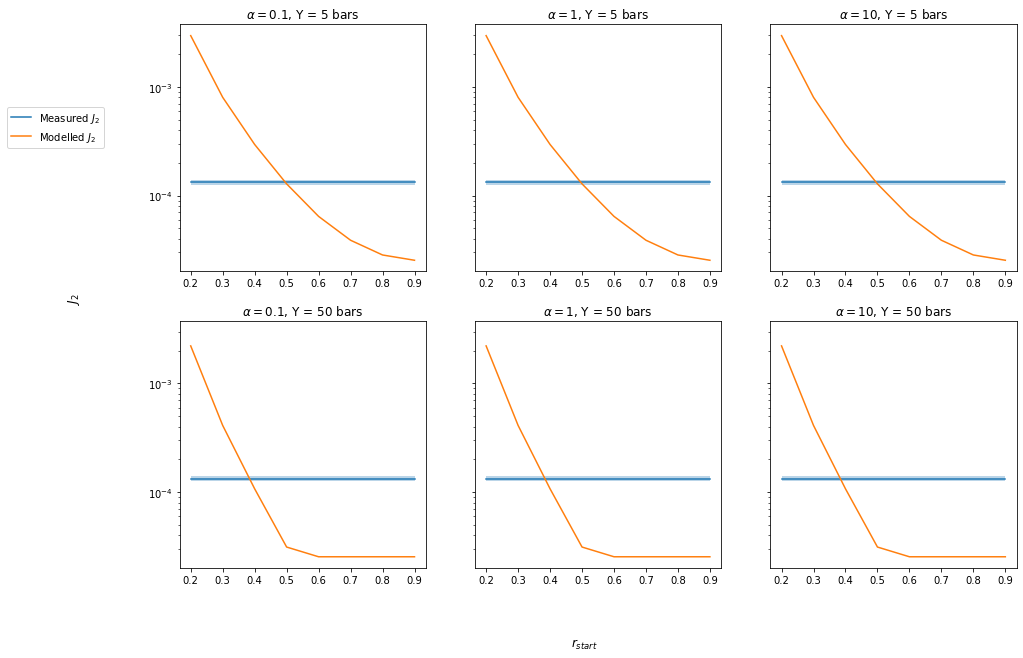

In [86]:
fig, ax = plt.subplots(2, 3,sharey = True)

ax[0][0].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[0][1].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[0][2].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[1][0].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[1][1].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[1][2].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)

ax[0][0].plot(r_start_range, J2_measured_list, label=r'Measured $J_2$')
ax[0][1].plot(r_start_range, J2_measured_list)
ax[0][2].plot(r_start_range, J2_measured_list)
ax[1][0].plot(r_start_range, J2_measured_list)
ax[1][1].plot(r_start_range, J2_measured_list)
ax[1][2].plot(r_start_range, J2_measured_list)


ax[0][0].plot(r_start_range, J2_list_010_5, label=r'Modelled $J_2$')
ax[0][1].plot(r_start_range, J2_list_100_5)
ax[0][2].plot(r_start_range, J2_list_1000_5)
ax[1][0].plot(r_start_range, J2_list_010_50)
ax[1][1].plot(r_start_range, J2_list_100_50)
ax[1][2].plot(r_start_range, J2_list_1000_50)



ax[0][0].set_title(r'$\alpha = 0.1$, Y = 5 bars')
ax[0][1].set_title(r'$\alpha = 1$, Y = 5 bars')
ax[0][2].set_title(r'$\alpha = 10$, Y = 5 bars')
ax[1][0].set_title(r'$\alpha = 0.1$, Y = 50 bars')
ax[1][1].set_title(r'$\alpha = 1$, Y = 50 bars')
ax[1][2].set_title(r'$\alpha = 10$, Y = 50 bars')


fig.set_size_inches(15, 10)
fig.supxlabel(r'$r_{start}$')
fig.supylabel(r'$J_2$')
ax[0][0].set_yscale('log')

ax[0][0].legend(loc=(-0.7,0.5))
plt.show()

In [87]:
theta_020_030_5, phi_020_030_5, diff_020_030_5, shape_020_030_5, fail_020_030_5, J2_020_030_5, eps_020_030_5, rot_020_030_5 = fracture_sim(t_unit, lat_radians, 0.2, 0.3, 5*u.bar)
theta_030_030_5, phi_030_030_5, diff_030_030_5, shape_030_030_5, fail_030_030_5, J2_030_030_5, eps_030_030_5, rot_030_030_5 = fracture_sim(t_unit, lat_radians, 0.3, 0.3, 5*u.bar)
theta_040_030_5, phi_040_030_5, diff_040_030_5, shape_040_030_5, fail_040_030_5, J2_040_030_5, eps_040_030_5, rot_040_030_5 = fracture_sim(t_unit, lat_radians, 0.4, 0.3, 5*u.bar)
theta_050_030_5, phi_050_030_5, diff_050_030_5, shape_050_030_5, fail_050_030_5, J2_050_030_5, eps_050_030_5, rot_050_030_5 = fracture_sim(t_unit, lat_radians, 0.5, 0.3, 5*u.bar)
theta_060_030_5, phi_060_030_5, diff_060_030_5, shape_060_030_5, fail_060_030_5, J2_060_030_5, eps_060_030_5, rot_060_030_5 = fracture_sim(t_unit, lat_radians, 0.6, 0.3, 5*u.bar)
theta_070_030_5, phi_070_030_5, diff_070_030_5, shape_070_030_5, fail_070_030_5, J2_070_030_5, eps_070_030_5, rot_070_030_5 = fracture_sim(t_unit, lat_radians, 0.7, 0.3, 5*u.bar)
theta_080_030_5, phi_080_030_5, diff_080_030_5, shape_080_030_5, fail_080_030_5, J2_080_030_5, eps_080_030_5, rot_080_030_5 = fracture_sim(t_unit, lat_radians, 0.8, 0.3, 5*u.bar)
theta_090_030_5, phi_090_030_5, diff_090_030_5, shape_090_030_5, fail_090_030_5, J2_090_030_5, eps_090_030_5, rot_090_030_5 = fracture_sim(t_unit, lat_radians, 0.9, 0.3, 5*u.bar)

theta_020_300_5, phi_020_300_5, diff_020_300_5, shape_020_300_5, fail_020_300_5, J2_020_300_5, eps_020_300_5, rot_020_300_5 = fracture_sim(t_unit, lat_radians, 0.2, 3, 5*u.bar)
theta_030_300_5, phi_030_300_5, diff_030_300_5, shape_030_300_5, fail_030_300_5, J2_030_300_5, eps_030_300_5, rot_030_300_5 = fracture_sim(t_unit, lat_radians, 0.3, 3, 5*u.bar)
theta_040_300_5, phi_040_300_5, diff_040_300_5, shape_040_300_5, fail_040_300_5, J2_040_300_5, eps_040_300_5, rot_040_300_5 = fracture_sim(t_unit, lat_radians, 0.4, 3, 5*u.bar)
theta_050_300_5, phi_050_300_5, diff_050_300_5, shape_050_300_5, fail_050_300_5, J2_050_300_5, eps_050_300_5, rot_050_300_5 = fracture_sim(t_unit, lat_radians, 0.5, 3, 5*u.bar)
theta_060_300_5, phi_060_300_5, diff_060_300_5, shape_060_300_5, fail_060_300_5, J2_060_300_5, eps_060_300_5, rot_060_300_5 = fracture_sim(t_unit, lat_radians, 0.6, 3, 5*u.bar)
theta_070_300_5, phi_070_300_5, diff_070_300_5, shape_070_300_5, fail_070_300_5, J2_070_300_5, eps_070_300_5, rot_070_300_5 = fracture_sim(t_unit, lat_radians, 0.7, 3, 5*u.bar)
theta_080_300_5, phi_080_300_5, diff_080_300_5, shape_080_300_5, fail_080_300_5, J2_080_300_5, eps_080_300_5, rot_080_300_5 = fracture_sim(t_unit, lat_radians, 0.8, 3, 5*u.bar)
theta_090_300_5, phi_090_300_5, diff_090_300_5, shape_090_300_5, fail_090_300_5, J2_090_300_5, eps_090_300_5, rot_090_300_5 = fracture_sim(t_unit, lat_radians, 0.9, 3, 5*u.bar)

Running model with r_start = 0.2*r_current, alpha = 0.3, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.3*r_current, alpha = 0.3, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.4*r_current, alpha = 0.3, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.5*r_current, alpha = 0.3, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.6*r_current, alpha = 0.3, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.7*r_current, alpha = 0.3, Y = 5.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.33

In [88]:
theta_020_030_50, phi_020_030_50, diff_020_030_50, shape_020_030_50, fail_020_030_50, J2_020_030_50, eps_020_030_50, rot_020_030_5 = fracture_sim(t_unit, lat_radians, 0.2, 0.3, 50*u.bar)
theta_030_030_50, phi_030_030_50, diff_030_030_50, shape_030_030_50, fail_030_030_50, J2_030_030_50, eps_030_030_50, rot_030_030_5 = fracture_sim(t_unit, lat_radians, 0.3, 0.3, 50*u.bar)
theta_040_030_50, phi_040_030_50, diff_040_030_50, shape_040_030_50, fail_040_030_50, J2_040_030_50, eps_040_030_50, rot_040_030_5 = fracture_sim(t_unit, lat_radians, 0.4, 0.3, 50*u.bar)
theta_050_030_50, phi_050_030_50, diff_050_030_50, shape_050_030_50, fail_050_030_50, J2_050_030_50, eps_050_030_50, rot_050_030_5 = fracture_sim(t_unit, lat_radians, 0.5, 0.3, 50*u.bar)
theta_060_030_50, phi_060_030_50, diff_060_030_50, shape_060_030_50, fail_060_030_50, J2_060_030_50, eps_060_030_50, rot_060_030_5 = fracture_sim(t_unit, lat_radians, 0.6, 0.3, 50*u.bar)
theta_070_030_50, phi_070_030_50, diff_070_030_50, shape_070_030_50, fail_070_030_50, J2_070_030_50, eps_070_030_50, rot_070_030_5 = fracture_sim(t_unit, lat_radians, 0.7, 0.3, 50*u.bar)
theta_080_030_50, phi_080_030_50, diff_080_030_50, shape_080_030_50, fail_080_030_50, J2_080_030_50, eps_080_030_50, rot_080_030_5 = fracture_sim(t_unit, lat_radians, 0.8, 0.3, 50*u.bar)
theta_090_030_50, phi_090_030_50, diff_090_030_50, shape_090_030_50, fail_090_030_50, J2_090_030_50, eps_090_030_50, rot_090_030_5 = fracture_sim(t_unit, lat_radians, 0.9, 0.3, 50*u.bar)

theta_020_300_50, phi_020_300_50, diff_020_300_50, shape_020_300_50, fail_020_300_50, J2_020_300_50, eps_020_300_50, rot_020_300_5 = fracture_sim(t_unit, lat_radians, 0.2, 3, 50*u.bar)
theta_030_300_50, phi_030_300_50, diff_030_300_50, shape_030_300_50, fail_030_300_50, J2_030_300_50, eps_030_300_50, rot_030_300_5 = fracture_sim(t_unit, lat_radians, 0.3, 3, 50*u.bar)
theta_040_300_50, phi_040_300_50, diff_040_300_50, shape_040_300_50, fail_040_300_50, J2_040_300_50, eps_040_300_50, rot_040_300_5 = fracture_sim(t_unit, lat_radians, 0.4, 3, 50*u.bar)
theta_050_300_50, phi_050_300_50, diff_050_300_50, shape_050_300_50, fail_050_300_50, J2_050_300_50, eps_050_300_50, rot_050_300_5 = fracture_sim(t_unit, lat_radians, 0.5, 3, 50*u.bar)
theta_060_300_50, phi_060_300_50, diff_060_300_50, shape_060_300_50, fail_060_300_50, J2_060_300_50, eps_060_300_50, rot_060_300_5 = fracture_sim(t_unit, lat_radians, 0.6, 3, 50*u.bar)
theta_070_300_50, phi_070_300_50, diff_070_300_50, shape_070_300_50, fail_070_300_50, J2_070_300_50, eps_070_300_50, rot_070_300_5 = fracture_sim(t_unit, lat_radians, 0.7, 3, 50*u.bar)
theta_080_300_50, phi_080_300_50, diff_080_300_50, shape_080_300_50, fail_080_300_50, J2_080_300_50, eps_080_300_50, rot_080_300_5 = fracture_sim(t_unit, lat_radians, 0.8, 3, 50*u.bar)
theta_090_300_50, phi_090_300_50, diff_090_300_50, shape_090_300_50, fail_090_300_50, J2_090_300_50, eps_090_300_50, rot_090_300_5 = fracture_sim(t_unit, lat_radians, 0.9, 3, 50*u.bar)

Running model with r_start = 0.2*r_current, alpha = 0.3, Y = 50.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.3*r_current, alpha = 0.3, Y = 50.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.4*r_current, alpha = 0.3, Y = 50.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.5*r_current, alpha = 0.3, Y = 50.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.6*r_current, alpha = 0.3, Y = 50.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.0712710581206575
1.339088822650822
Running model with r_start = 0.7*r_current, alpha = 0.3, Y = 50.0 bars
0.0
0.26781776453016437
0.5356355290603287
0.8034532935904931
1.071271058120657

In [89]:
J2_list = [J2_020_010_5, J2_030_010_5, J2_040_010_5, J2_050_010_5, J2_060_010_5, J2_070_010_5, J2_080_010_5, J2_090_010_5, J2_020_030_5, J2_030_030_5, J2_040_030_5, J2_050_030_5, J2_060_030_5, J2_070_030_5, J2_080_030_5, J2_090_030_5, J2_020_100_5, J2_030_100_5, J2_040_100_5, J2_050_100_5, J2_060_100_5, J2_070_100_5, J2_080_100_5, J2_090_100_5, J2_020_300_5, J2_030_300_5, J2_040_300_5, J2_050_300_5, J2_060_300_5, J2_070_300_5, J2_080_300_5, J2_090_300_5, J2_020_1000_5, J2_030_1000_5, J2_040_1000_5, J2_050_1000_5, J2_060_1000_5, J2_070_1000_5, J2_080_1000_5, J2_090_1000_5, J2_020_010_50, J2_030_010_50, J2_040_010_50, J2_050_010_50, J2_060_010_50, J2_070_010_50, J2_080_010_50, J2_090_010_50, J2_020_030_50, J2_030_030_50, J2_040_030_50, J2_050_030_50, J2_060_030_50, J2_070_030_50, J2_080_030_50, J2_090_030_50, J2_020_100_50, J2_030_100_50, J2_040_100_50, J2_050_100_50, J2_060_100_50, J2_070_100_50, J2_080_100_50, J2_090_100_50, J2_020_300_50, J2_030_300_50, J2_040_300_50, J2_050_300_50, J2_060_300_50, J2_070_300_50, J2_080_300_50, J2_090_300_50, J2_020_1000_50, J2_030_1000_50, J2_040_1000_50, J2_050_1000_50, J2_060_1000_50, J2_070_1000_50, J2_080_1000_50, J2_090_1000_50]

J2_total = []

for i in range(len(J2_list)):
    J2_total.append(np.sum(J2_list[i]))
    
J2_list_010_5 = []
J2_list_100_5 = []
J2_list_1000_5 = []
J2_list_010_50 = []
J2_list_100_50 = []
J2_list_1000_50 = []
J2_list_030_5 = []
J2_list_300_5 = []
J2_list_030_50 = []
J2_list_300_50 = []

# J2_measured_list = [J2_measured for i in range(len(r_start_range))]
# J2_under_list = [J2_measured - J2_unc for i in range(len(r_start_range))]
# J2_over_list = [J2_measured + J2_unc for i in range(len(r_start_range))]


for i in range(len(J2_total)):
    if i < 8:
        J2_list_010_5.append(J2_total[i])
    if 8 <= i < 16:
        J2_list_030_5.append(J2_total[i])
    if 16 <= i < 24:
        J2_list_100_5.append(J2_total[i])
    if 24 <= i < 32:
        J2_list_300_5.append(J2_total[i])
    if 32 <= i < 40:
        J2_list_1000_5.append(J2_total[i])
    if 40 <= i < 48:
        J2_list_010_50.append(J2_total[i])
    if 48 <= i < 56:
        J2_list_030_50.append(J2_total[i])
    if 56 <= i < 64:
        J2_list_100_50.append(J2_total[i])
    if 64 <= i < 72:
        J2_list_300_50.append(J2_total[i])
    if 72 <= i < 80:
        J2_list_1000_50.append(J2_total[i])

        

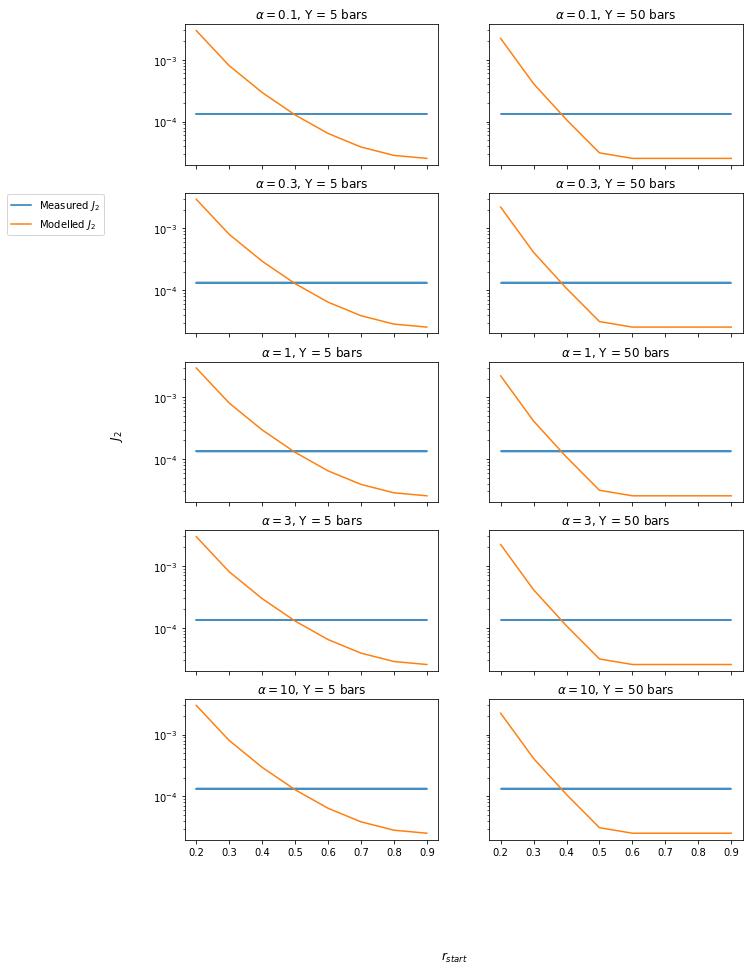

In [121]:
fig, ax = plt.subplots(5, 2,sharey = True, sharex = True)

ax[0][0].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[0][1].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[1][0].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[1][1].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[2][0].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[2][1].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[3][0].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[3][1].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[4][0].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)
ax[4][1].fill_between(r_start_range, J2_under_list, J2_over_list, alpha = 0.3)

ax[0][0].plot(r_start_range, J2_measured_list, label=r'Measured $J_2$')
ax[0][1].plot(r_start_range, J2_measured_list)
ax[1][0].plot(r_start_range, J2_measured_list)
ax[1][1].plot(r_start_range, J2_measured_list)
ax[2][0].plot(r_start_range, J2_measured_list)
ax[2][1].plot(r_start_range, J2_measured_list)
ax[3][0].plot(r_start_range, J2_measured_list)
ax[3][1].plot(r_start_range, J2_measured_list)
ax[4][0].plot(r_start_range, J2_measured_list)
ax[4][1].plot(r_start_range, J2_measured_list)


ax[0][0].plot(r_start_range, J2_list_010_5, label=r'Modelled $J_2$')
ax[1][0].plot(r_start_range, J2_list_030_5)
ax[2][0].plot(r_start_range, J2_list_100_5)
ax[3][0].plot(r_start_range, J2_list_300_5)
ax[4][0].plot(r_start_range, J2_list_1000_5)
ax[0][1].plot(r_start_range, J2_list_010_50)
ax[1][1].plot(r_start_range, J2_list_030_50)
ax[2][1].plot(r_start_range, J2_list_100_50)
ax[3][1].plot(r_start_range, J2_list_300_50)
ax[4][1].plot(r_start_range, J2_list_1000_50)


ax[0][0].set_title(r'$\alpha = 0.1$, Y = 5 bars')
ax[0][1].set_title(r'$\alpha = 0.1$, Y = 50 bars')
ax[1][0].set_title(r'$\alpha = 0.3$, Y = 5 bars')
ax[1][1].set_title(r'$\alpha = 0.3$, Y = 50 bars')
ax[2][0].set_title(r'$\alpha = 1$, Y = 5 bars')
ax[2][1].set_title(r'$\alpha = 1$, Y = 50 bars')
ax[3][0].set_title(r'$\alpha = 3$, Y = 5 bars')
ax[3][1].set_title(r'$\alpha = 3$, Y = 50 bars')
ax[4][0].set_title(r'$\alpha = 10$, Y = 5 bars')
ax[4][1].set_title(r'$\alpha = 10$, Y = 50 bars')


fig.set_size_inches(10, 15)
fig.supxlabel(r'$r_{start}$')
fig.supylabel(r'$J_2$')
ax[0][0].set_yscale('log')

ax[0][0].legend(loc=(-0.7,-0.5))
plt.show()

/var/folders/5t/8zdtbb_9051_btzndt6k8rw00000gn/T/ipykernel_87393/3883066392.py:34: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb1 = fig.colorbar(ax1, label='J2')


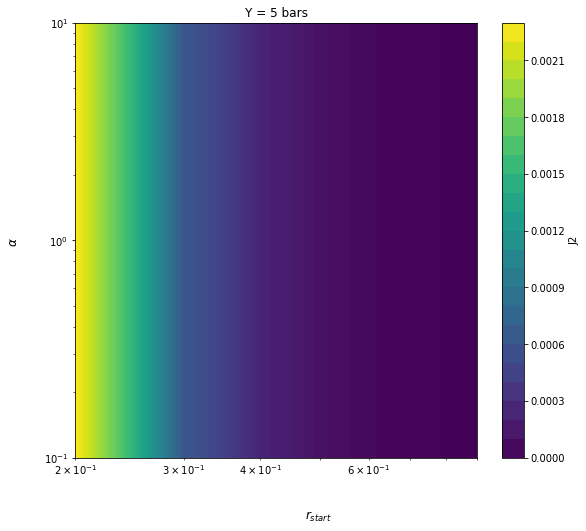

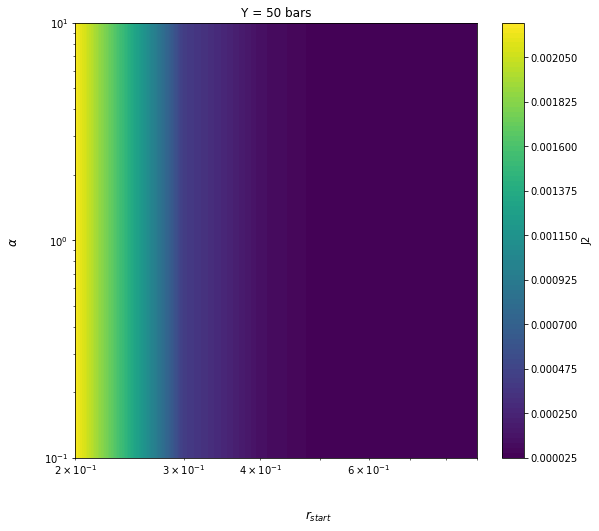

In [150]:
r_start_range = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alpha_range = [0.1, 0.3, 1, 3, 10]

J2_5bars = np.zeros((len(alpha_range), len(r_start_range)))
J2_50bars = np.zeros((len(alpha_range), len(r_start_range)))

for j in range(len(alpha_range)):
    for i in range(len(r_start_range)):
        if j == 0:
            J2_5bars[j][i] = J2_list_010_5[i]
            J2_50bars[j][i] = J2_list_010_50[i]
        if j == 1:
            J2_5bars[j][i] = J2_list_030_5[i]
            J2_50bars[j][i] = J2_list_030_50[i]
        if j == 2:
            J2_5bars[j][i] = J2_list_100_5[i]
            J2_50bars[j][i] = J2_list_100_50[i]
        if j == 3:
            J2_5bars[j][i] = J2_list_300_5[i]
            J2_50bars[j][i] = J2_list_300_50[i]
        if j == 4:
            J2_5bars[j][i] = J2_list_1000_5[i]
            J2_50bars[j][i] = J2_list_1000_50[i]

fig, ax = plt.subplots(1, 1, sharex = True, sharey = True)
ax0 = ax.contourf(r_start_range, alpha_range, J2_5bars, 100)
# ax1 = ax[1].contourf(r_start_range, alpha_range, J2_50bars, 25)
ax.set_title('Y = 5 bars')
# ax[1].set_title('Y = 50 bars')
ax.set_yscale('log')
ax.set_xscale('log')
# cont = ax.contour(J2_measured)
# cb0 = fig.colorbar(ax0, label='J2')
cb1 = fig.colorbar(ax1, label='J2')

fig.supxlabel(r'$r_{start}$')
fig.supylabel(r'$\alpha$')
fig.set_size_inches(9, 8)

plt.show()

fig, ax = plt.subplots(1, 1, sharex = True, sharey = True)
# ax0 = ax.contourf(r_start_range, alpha_range, J2_5bars, 100)
ax1 = ax.contourf(r_start_range, alpha_range, J2_50bars, 100)
ax.set_title('Y = 50 bars')
# ax[1].set_title('Y = 50 bars')
ax.set_yscale('log')
ax.set_xscale('log')
# cont = ax.contour(J2_measured)
# cb0 = fig.colorbar(ax0, label='J2')
cb1 = fig.colorbar(ax1, label='J2')

fig.supxlabel(r'$r_{start}$')
fig.supylabel(r'$\alpha$')
fig.set_size_inches(9, 8)

plt.show()